# Nucleus Segmentation of IDC Pathology Images with TIAToolbox HoVer-Net

<a href="https://colab.research.google.com/github/fedorov/idc-tiatoolbox/blob/main/notebooks/06_nucleus_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

**Nucleus instance segmentation** detects and classifies individual cell nuclei in tissue images. Unlike semantic segmentation (Notebook 05) which labels pixels, instance segmentation identifies each nucleus as a separate object with its own boundary, type, and properties.

This notebook demonstrates TIAToolbox's `NucleusInstanceSegmentor` with the **HoVer-Net** model, which classifies nuclei into 6 types:

1. **Neoplastic epithelial** - cancer cells
2. **Non-neoplastic epithelial** - normal epithelial cells
3. **Inflammatory** - immune cells
4. **Connective** - fibroblasts, endothelial cells
5. **Dead** - necrotic/apoptotic cells
6. **Background** - non-nucleus

**GPU required** for reasonable inference time.

## Installation

Run the cell below to install dependencies. **On Colab, the runtime will automatically restart** after installation to pick up the updated numpy version. After the restart, continue from the imports cell below.

In [ ]:
%%capture
%pip install "tiatoolbox==1.6.0" idc-index openslide-bin "numcodecs<0.16"

# Restart runtime to pick up updated numpy (required on Colab)
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
import os
import joblib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

from idc_index import IDCClient
from tiatoolbox.wsicore.wsireader import WSIReader
from tiatoolbox.models.engine.nucleus_instance_segmentor import NucleusInstanceSegmentor

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    try:
        torch.zeros(1, device="cuda")
    except RuntimeError:
        print("CUDA available but not functional — falling back to CPU")
        device = "cpu"
print(f"Using device: {device}")
if device == "cpu":
    print("WARNING: GPU is required for reasonable inference time.")
    print("In Colab: Runtime > Change runtime type > T4 GPU")

  check_for_updates()



Using device: cuda


## Reproducibility Information

Capture execution timestamp and environment details for reproducibility.

In [ ]:
import datetime, os, platform, subprocess, sys
from importlib.metadata import version, PackageNotFoundError

print(f"Executed: {datetime.datetime.now(datetime.timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC')}")
print(f"Platform: {platform.platform()}")
print(f"Python:   {sys.version}")

# Detect Colab environment and runtime version
try:
    import google.colab  # noqa: F401
    colab_env = "Google Colab"
    # Try to get the Colab runtime version (e.g., "2026.01")
    colab_release = os.environ.get("COLAB_RELEASE_TAG")
    if colab_release:
        colab_env += f" (runtime {colab_release})"
    else:
        # Fall back to google-colab package version as a proxy
        try:
            colab_env += f" (google-colab {version('google-colab')})"
        except PackageNotFoundError:
            pass
    print(f"Runtime:  {colab_env}")
except ImportError:
    print("Runtime:  Local")

print("\nKey package versions:")
for pkg in ["tiatoolbox", "idc-index", "numpy", "matplotlib",
            "openslide-bin", "torch", "highdicom", "wsidicom", "shapely"]:
    try:
        print(f"  {pkg}: {version(pkg)}")
    except PackageNotFoundError:
        pass

try:
    import psutil
    ram = psutil.virtual_memory()
    print(f"\nRAM: {ram.total / (1024**3):.1f} GB total, {ram.available / (1024**3):.1f} GB available")
except ImportError:
    pass

try:
    result = subprocess.run(
        ["nvidia-smi", "--query-gpu=name,memory.total,driver_version", "--format=csv,noheader"],
        capture_output=True, text=True, timeout=5,
    )
    if result.returncode == 0:
        print(f"GPU:  {result.stdout.strip()}")
    else:
        print("GPU:  Not available")
except (FileNotFoundError, subprocess.TimeoutExpired):
    print("GPU:  Not available")

Executed: 2026-02-18 19:46:53 UTC
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Python:   3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Runtime:  Google Colab (runtime release-colab-external_20260213-060047_RC00)

Key package versions:
  tiatoolbox: 1.6.0
  idc-index: 0.11.9
  numpy: 1.26.4
  matplotlib: 3.9.3
  openslide-bin: 4.0.0.11
  torch: 2.5.1
  wsidicom: 0.22.0
  shapely: 2.0.6

RAM: 12.7 GB total, 10.4 GB available
GPU:  Tesla T4, 15360 MiB, 580.82.07


## 1. Select and Download a Slide

In [ ]:
idc_client = IDCClient()
idc_client.fetch_index("sm_index")

# Select a breast cancer slide (TCGA-BRCA)
candidates = idc_client.sql_query("""
    SELECT
        i.SeriesInstanceUID,
        i.PatientID,
        ROUND(i.series_size_MB, 1) as size_mb,
        s.ObjectiveLensPower,
        s.max_TotalPixelMatrixColumns as width,
        s.max_TotalPixelMatrixRows as height,
        s.min_PixelSpacing_2sf as pixel_spacing_mm
    FROM sm_index s
    JOIN index i ON s.SeriesInstanceUID = i.SeriesInstanceUID
    WHERE i.collection_id = 'tcga_brca'
        AND s.ObjectiveLensPower >= 20
    ORDER BY i.series_size_MB ASC
    LIMIT 5
""")

selected = candidates.iloc[0]
series_uid = selected['SeriesInstanceUID']
print(f"Selected: {selected['PatientID']}, {selected['SeriesInstanceUID']}, {selected['size_mb']} MB")
print(f"  Dimensions: {selected['width']}x{selected['height']} @ {selected['ObjectiveLensPower']}x")

Selected: TCGA-A7-A26J, 1.3.6.1.4.1.5962.99.1.1247079754.248369703.1637629652298.2.0, 18.2 MB
  Dimensions: 8618x7243 @ 40x


In [ ]:
download_dir = './slides'
os.makedirs(download_dir, exist_ok=True)

idc_client.download_from_selection(
    downloadDir=download_dir,
    seriesInstanceUID=[series_uid],
    dirTemplate='%SeriesInstanceUID'
)

slide_path = os.path.join(download_dir, series_uid)
reader = WSIReader.open(slide_path)

# DICOMWSIReader may not populate objective_power or mpp
info = reader.info
if info.objective_power is None:
    info.objective_power = float(selected['ObjectiveLensPower'])
if info.mpp is None:
    pixel_spacing_um = float(selected['pixel_spacing_mm']) * 1000
    info.mpp = np.array([pixel_spacing_um, pixel_spacing_um])

print(f"Opened: {type(reader).__name__}, dimensions: {info.slide_dimensions}")

Opened: DICOMWSIReader, dimensions: (8618, 7243)


## 2. Extract a Tissue Tile

HoVer-Net works at high resolution (0.25 mpp, ~40x). For this demo, we'll extract a single tile to keep inference time manageable.

Tile shape: (2048, 2048, 3)


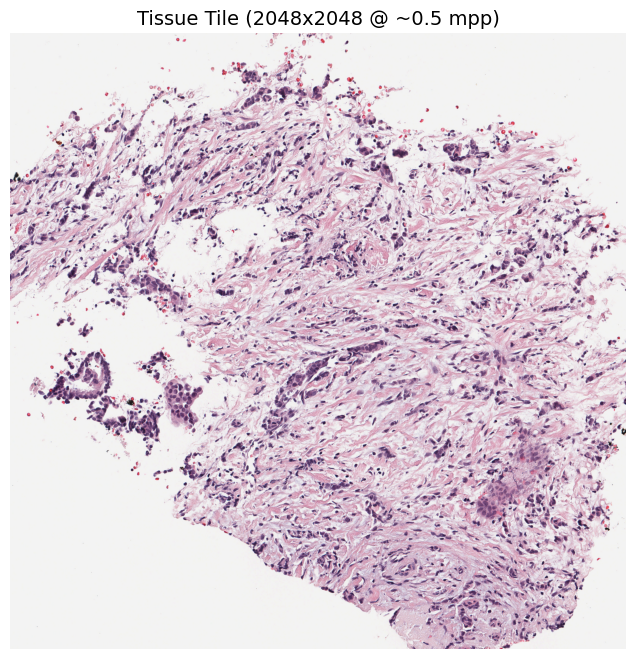

In [ ]:
# Find tissue region
thumbnail = reader.slide_thumbnail(resolution=1.25, units="power")
gray = np.mean(thumbnail, axis=2)
tissue_mask = gray < 200
tissue_coords = np.argwhere(tissue_mask)

center_y, center_x = tissue_coords.mean(axis=0).astype(int)
slide_w, slide_h = info.slide_dimensions

baseline_x = int(center_x * slide_w / thumbnail.shape[1])
baseline_y = int(center_y * slide_h / thumbnail.shape[0])

# Extract a 2048x2048 tile in baseline coordinates
# DICOMWSIReader has coordinate issues at non-native resolutions,
# so we read at native resolution and resize if needed.
tile_size = 2048
baseline_mpp = float(info.mpp[0])
target_mpp = 0.5

baseline_extent = int(tile_size * target_mpp / baseline_mpp)

bounds = (
    max(0, baseline_x - baseline_extent // 2),
    max(0, baseline_y - baseline_extent // 2),
    min(slide_w, baseline_x + baseline_extent // 2),
    min(slide_h, baseline_y + baseline_extent // 2),
)

tile = reader.read_bounds(
    bounds=bounds,
    resolution=info.objective_power,
    units="power",
)

# Resize to target tile size if native mpp differs from target
from PIL import Image
if tile.shape[0] != tile_size or tile.shape[1] != tile_size:
    tile = np.array(Image.fromarray(tile).resize((tile_size, tile_size), Image.LANCZOS))

print(f"Tile shape: {tile.shape}")

plt.figure(figsize=(8, 8))
plt.imshow(tile)
plt.title(f"Tissue Tile ({tile_size}x{tile_size} @ ~{target_mpp} mpp)", fontsize=14)
plt.axis('off')
plt.show()

In [ ]:
# Save tile for the segmentor
from PIL import Image
tile_path = './tile_for_nucleus_seg.png'
Image.fromarray(tile).save(tile_path)
print(f"Tile saved to {tile_path}")

Tile saved to ./tile_for_nucleus_seg.png


## 3. Run HoVer-Net Nucleus Instance Segmentation

**HoVer-Net** uses horizontal and vertical distance maps to separate touching/overlapping nuclei. The `hovernet_fast-pannuke` variant was trained on the [PanNuke](https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke/) dataset, which includes tissue from 19 different organs.

In [ ]:
segmentor = NucleusInstanceSegmentor(
    pretrained_model="hovernet_fast-pannuke",
    num_loader_workers=0,
    num_postproc_workers=0,
    batch_size=8,
)

print("HoVer-Net (PanNuke) loaded.")
print("Nucleus types: 0=Background, 1=Neoplastic, 2=Non-neoplastic epithelial, 3=Inflammatory, 4=Connective, 5=Dead")

  saved_state_dict = torch.load(pretrained_weights, map_location="cpu")



HoVer-Net (PanNuke) loaded.
Nucleus types: 0=Background, 1=Neoplastic, 2=Non-neoplastic epithelial, 3=Inflammatory, 4=Connective, 5=Dead


In [ ]:
# Run inference
output = segmentor.predict(
    imgs=[tile_path],
    mode="tile",
    save_dir="./nuc_seg_results/",
    resolution=1.0,
    units="baseline",
    device=device,
)

print("Nucleus segmentation complete!")

Process Batch: 100%|##############################| 2/2 [00:01<00:00,  1.71it/s]


Nucleus segmentation complete!


## 4. Load and Explore Results

HoVer-Net results are saved as `.dat` files (Python dictionaries serialized with joblib). Each entry contains:
- `box`: Bounding box [x, y, width, height]
- `centroid`: Center point [x, y]
- `contour`: Boundary polygon
- `prob`: Classification confidence
- `type`: Nucleus type (1-5)

In [ ]:
# Load results
result_path = output[0][1] + '.dat'
nuclei = joblib.load(result_path)

print(f"Total nuclei detected: {len(nuclei)}")

# Show structure of first nucleus
if len(nuclei) > 0:
    first_key = list(nuclei.keys())[0]
    print(f"\nExample nucleus (key={first_key}):")
    for k, v in nuclei[first_key].items():
        if k == 'contour':
            print(f"  {k}: array with {len(v)} points")
        else:
            print(f"  {k}: {v}")

Total nuclei detected: 2186

Example nucleus (key=0974986c070b46d6be30b429bbe1dbad):
  box: [768  98 783 108]
  centroid: [775.10784314 102.57843137]
  contour: array with 20 points
  prob: 0.5686274454056133
  type: 4


In [ ]:
# Count by nucleus type
type_names = {
    0: 'Background',
    1: 'Neoplastic',
    2: 'Non-neoplastic epithelial',
    3: 'Inflammatory',
    4: 'Connective',
    5: 'Dead',
}

type_counts = {}
for nuc in nuclei.values():
    t = nuc['type']
    type_counts[t] = type_counts.get(t, 0) + 1

print("Nucleus type distribution:")
print("-" * 45)
for t in sorted(type_counts.keys()):
    name = type_names.get(t, f'Type {t}')
    count = type_counts[t]
    pct = count / len(nuclei) * 100
    print(f"  {name:30s}: {count:5d} ({pct:.1f}%)")

Nucleus type distribution:
---------------------------------------------
  Background                    :    19 (0.9%)
  Neoplastic                    :   159 (7.3%)
  Non-neoplastic epithelial     :   482 (22.0%)
  Inflammatory                  :   773 (35.4%)
  Connective                    :   753 (34.4%)


## 5. Visualize Nucleus Contours

Let's overlay the detected nucleus contours on the tissue tile, color-coded by type.

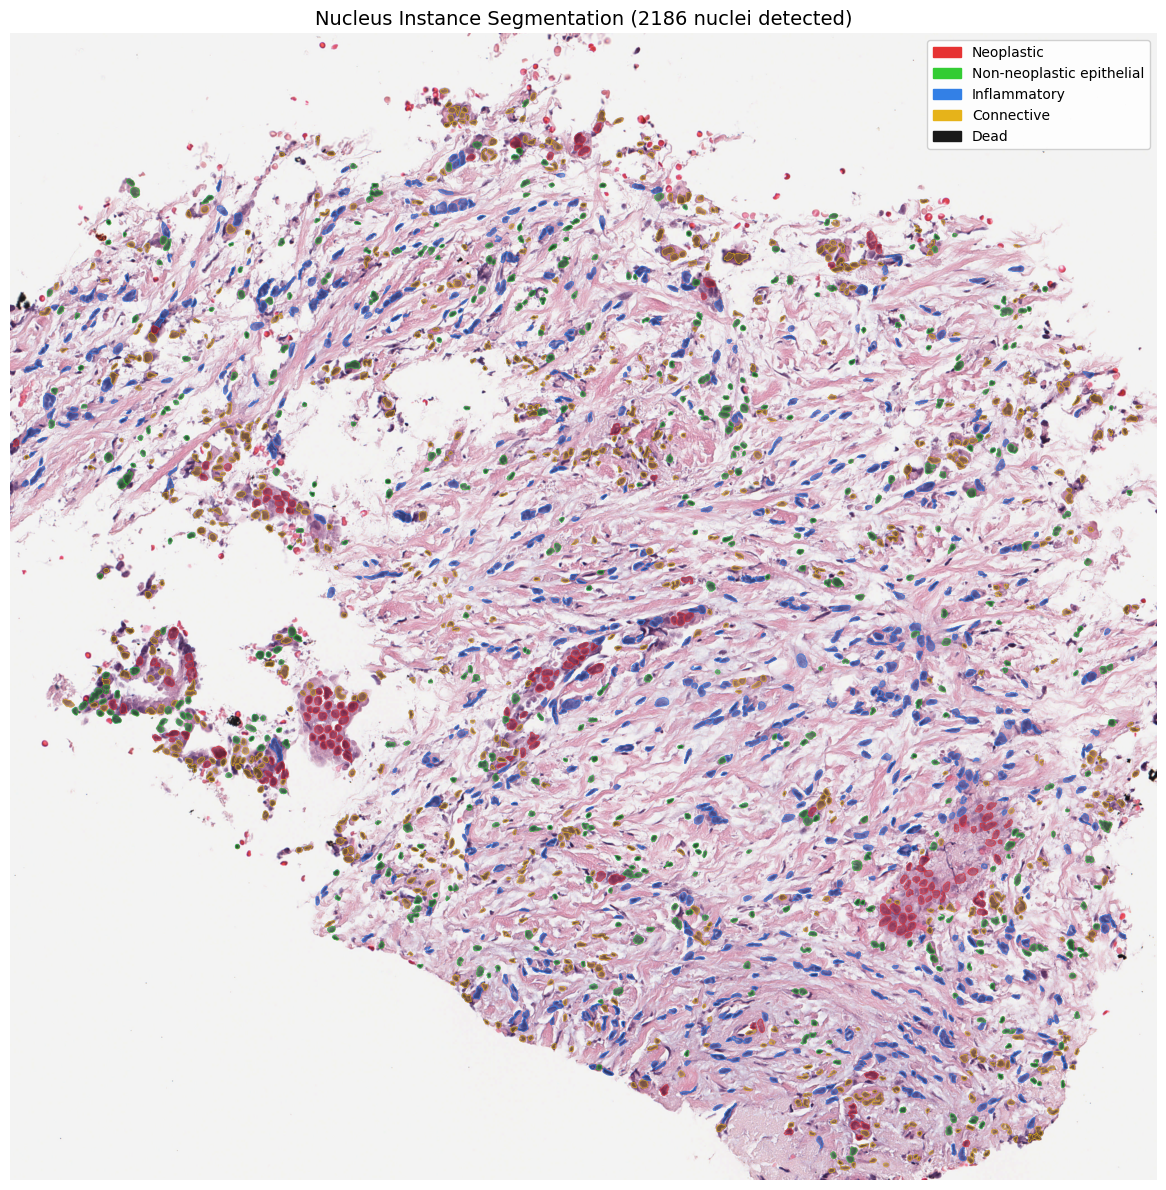

In [ ]:
# Define colors for each nucleus type
type_colors = {
    1: [0.9, 0.2, 0.2],   # Neoplastic - red
    2: [0.2, 0.8, 0.2],   # Non-neoplastic epithelial - green
    3: [0.2, 0.5, 0.9],   # Inflammatory - blue
    4: [0.9, 0.7, 0.1],   # Connective - yellow
    5: [0.1, 0.1, 0.1],   # Dead - black
}

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(tile)

for nuc in nuclei.values():
    nuc_type = nuc['type']
    if nuc_type == 0:
        continue  # Skip background
    contour = nuc['contour']
    color = type_colors.get(nuc_type, [0.5, 0.5, 0.5])
    polygon = Polygon(contour, closed=True, fill=True,
                      facecolor=(*color, 0.3), edgecolor=(*color, 0.8),
                      linewidth=0.5)
    ax.add_patch(polygon)

# Add legend
legend_patches = [
    mpatches.Patch(color=color, label=type_names[t])
    for t, color in type_colors.items()
]
ax.legend(handles=legend_patches, loc='upper right', fontsize=10, framealpha=0.9)

ax.set_title(f"Nucleus Instance Segmentation ({len(nuclei)} nuclei detected)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

### Zoomed-In View

Let's zoom into a smaller region to see individual nuclei more clearly.

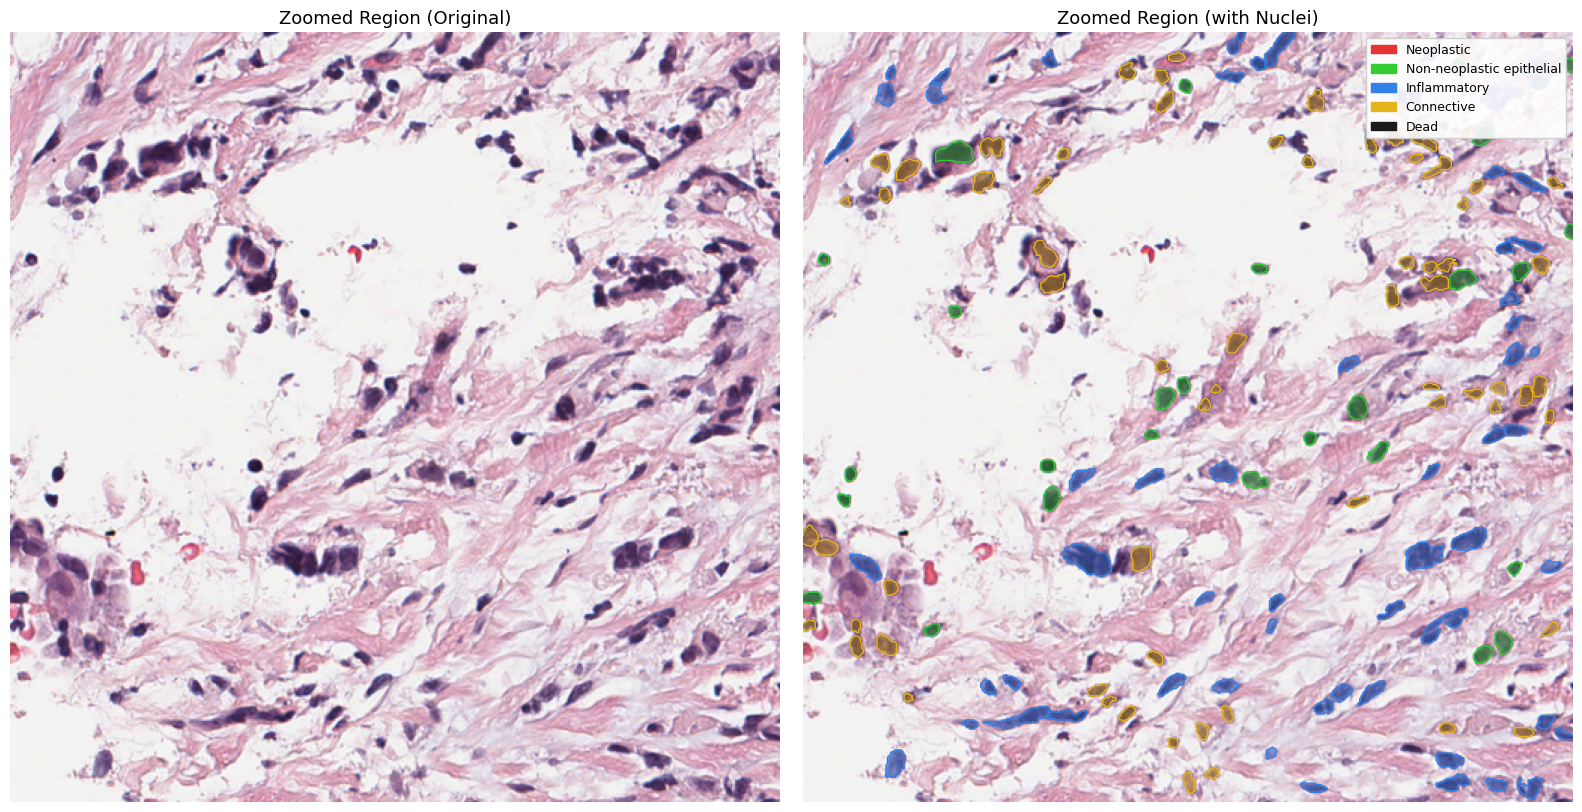

In [ ]:
# Zoom into a 512x512 region
zoom_x, zoom_y = tile_size // 4, tile_size // 4
zoom_size = 512

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Original zoomed
zoomed_tile = tile[zoom_y:zoom_y+zoom_size, zoom_x:zoom_x+zoom_size]
axes[0].imshow(zoomed_tile)
axes[0].set_title("Zoomed Region (Original)", fontsize=13)
axes[0].axis('off')

# With nucleus overlays
axes[1].imshow(zoomed_tile)

for nuc in nuclei.values():
    nuc_type = nuc['type']
    if nuc_type == 0:
        continue
    centroid = nuc['centroid']
    # Check if nucleus is in the zoomed region
    if (zoom_x <= centroid[0] < zoom_x + zoom_size and
        zoom_y <= centroid[1] < zoom_y + zoom_size):
        contour = nuc['contour'] - np.array([zoom_x, zoom_y])
        color = type_colors.get(nuc_type, [0.5, 0.5, 0.5])
        polygon = Polygon(contour, closed=True, fill=True,
                          facecolor=(*color, 0.4), edgecolor=(*color, 1.0),
                          linewidth=1)
        axes[1].add_patch(polygon)

legend_patches = [
    mpatches.Patch(color=color, label=type_names[t])
    for t, color in type_colors.items()
]
axes[1].legend(handles=legend_patches, loc='upper right', fontsize=9, framealpha=0.9)
axes[1].set_title("Zoomed Region (with Nuclei)", fontsize=13)
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 6. Nuclear Morphometry Statistics

The per-nucleus data allows us to compute morphometric features like nucleus area, aspect ratio, and spatial density.

In [ ]:
from shapely.geometry import Polygon as ShapelyPolygon

# Compute areas for each nucleus
areas_by_type = {t: [] for t in type_colors.keys()}

for nuc in nuclei.values():
    nuc_type = nuc['type']
    if nuc_type == 0:
        continue
    contour = nuc['contour']
    if len(contour) >= 3:
        poly = ShapelyPolygon(contour)
        if poly.is_valid:
            areas_by_type[nuc_type].append(poly.area)

# Summary statistics
print("Nuclear area statistics (pixels^2):")
print("-" * 55)
print(f"{'Type':30s}  {'Count':>6s}  {'Mean':>8s}  {'Std':>8s}")
print("-" * 55)
for t in sorted(areas_by_type.keys()):
    areas = areas_by_type[t]
    if len(areas) > 0:
        name = type_names[t]
        print(f"  {name:28s}  {len(areas):6d}  {np.mean(areas):8.1f}  {np.std(areas):8.1f}")

Nuclear area statistics (pixels^2):
-------------------------------------------------------
Type                             Count      Mean       Std
-------------------------------------------------------
  Neoplastic                       155     155.0      65.5
  Non-neoplastic epithelial        478      93.5      45.0
  Inflammatory                     754     120.2      65.8
  Connective                       734      84.3      45.0


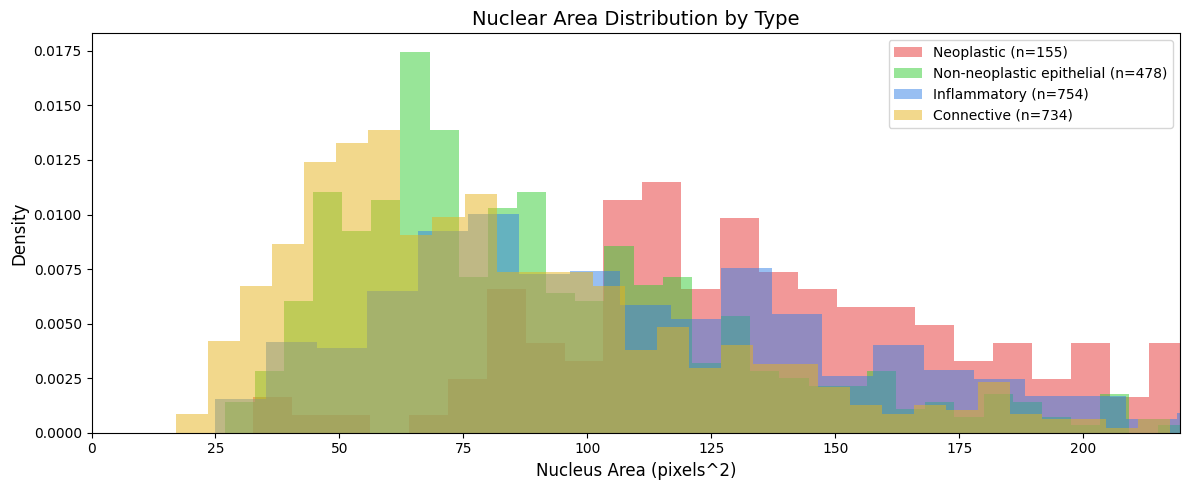

In [ ]:
# Plot area distributions by type
fig, ax = plt.subplots(figsize=(12, 5))

for t in sorted(areas_by_type.keys()):
    areas = areas_by_type[t]
    if len(areas) > 10:
        color = type_colors[t]
        ax.hist(areas, bins=50, alpha=0.5, color=color,
                label=f"{type_names[t]} (n={len(areas)})", density=True)

ax.set_xlabel("Nucleus Area (pixels^2)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("Nuclear Area Distribution by Type", fontsize=14)
ax.legend(fontsize=10)
ax.set_xlim(0, np.percentile([a for areas in areas_by_type.values() for a in areas], 95))
plt.tight_layout()
plt.show()

## Summary

In this notebook, we learned how to:

- Use `NucleusInstanceSegmentor` with the pretrained `hovernet_fast-pannuke` model
- Run nucleus detection on a tile extracted from an IDC slide
- Load and explore per-nucleus results (bounding boxes, centroids, contours, types, probabilities)
- Visualize nucleus contours color-coded by type (neoplastic, inflammatory, connective, etc.)
- Compute nuclear morphometry statistics (area distributions)

**Next:** [Notebook 07](07_comparing_with_idc_annotations.ipynb) compares TIAToolbox HoVer-Net results with IDC's Pan-Cancer-Nuclei-Seg-DICOM annotations for quantitative validation.

## Acknowledgments

- **IDC:** Fedorov, A., et al. "National Cancer Institute Imaging Data Commons: Toward Transparency, Reproducibility, and Scalability in Imaging Artificial Intelligence." *RadioGraphics* 43.12 (2023). https://doi.org/10.1148/rg.230180
- **TIAToolbox:** Pocock, J., et al. "TIAToolbox as an end-to-end library for advanced tissue image analytics." *Communications Medicine* 2, 120 (2022). https://doi.org/10.1038/s43856-022-00186-5
- **HoVer-Net:** Graham, S., et al. "Hover-Net: Simultaneous segmentation and classification of nuclei in multi-tissue histology images." *Medical Image Analysis* 58 (2019). https://doi.org/10.1016/j.media.2019.101563
- **PanNuke:** Gamper, J., et al. "PanNuke Dataset Extension, Insights and Baselines." arXiv:2003.10778 (2020). https://doi.org/10.48550/arXiv.2003.10778